In [1]:
#from attention import AttentionLayer
from keras.layers.attention import AttentionLayer



Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow
import pandas as pd 
import re
from bs4 import BeautifulSoup     #Beautiful Soup transforms a complex HTML document into a complex tree of Python objects
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:

data=pd.read_csv("Reviews.csv",nrows=30000)

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28676 entries, 0 to 29999
Data columns (total 10 columns):
Id                        28676 non-null int64
ProductId                 28676 non-null object
UserId                    28676 non-null object
ProfileName               28676 non-null object
HelpfulnessNumerator      28676 non-null int64
HelpfulnessDenominator    28676 non-null int64
Score                     28676 non-null int64
Time                      28676 non-null int64
Summary                   28676 non-null object
Text                      28676 non-null object
dtypes: int64(5), object(5)
memory usage: 2.4+ MB


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have","you're": "you are", "you've": "you have"}

In [7]:

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newstring=text.lower()
    newstring=BeautifulSoup(newstring,"lxml").text
    newstring=re.sub(r'\([^)]*\)','',newstring)
    newstring=re.sub(r'"','',newstring)
    newstring=' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newstring.split(" ")])
    newstring=re.sub(r"'s\b",'',newstring)
    newstring = re.sub("[^a-zA-Z]", " ", newstring) 
    newstring = re.sub('[m]{2,}', 'mm', newstring)
    
    if(num==0):
        tokens = [w for w in newstring.split() if not w in stop_words]
    else:
        tokens=newstring.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()
    


In [8]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [9]:
print(cleaned_text[:5])

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [10]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [11]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [12]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [13]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
%matplotlib inline 

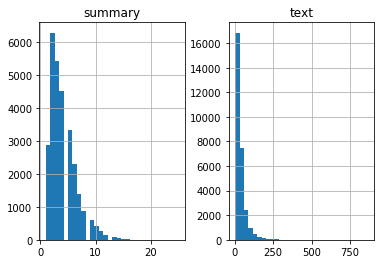

In [14]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [15]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.943771596104848


In [16]:
max_text_len=30
max_summary_len=8

In [17]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [18]:
#Now we will add some special token at atsrt and at the end of summary

df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [19]:
#spliting into training and testing data

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [20]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [21]:
thresh=4     #words below this count considered as rare words

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.31929675315469
Total Coverage of rare words: 5.210999853155373


In [22]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq =x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

In [23]:
x_voc

4752

In [24]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [25]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.84362139917695
Total Coverage of rare words: 8.987963039126978


In [26]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [27]:

y_tokenizer.word_counts['sostok'],len(y_tr)


(13970, 13970)

In [28]:

y_voc

932

In [29]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [30]:

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)


In [33]:
#model = load_model('model.h5', custom_objects={'AttentionLayer': AttentionLayer})
# load the model
from  tensorflow.keras.models import model_from_json
j_file = open('model.json', 'r')
model = j_file.read()
j_file.close()
model = model_from_json(model,custom_objects={'AttentionLayer': AttentionLayer})


# load the weights
model.load_weights("model_2.h5")

In [36]:
from keras import backend as K 
K.clear_session()
# 
# latent_dim = 300
# embedding_dim=100
# 
# # Encoder
# encoder_inputs = model.input[0]
# 
# #embedding layer
# enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
# 
# #encoder lstm 1
# encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 
# #encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 
# #encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
# 
# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = model.input[1]
# 
# #embedding layer
# dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
# dec_emb = dec_emb_layer(decoder_inputs)
# 
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
# decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
# 
# # Attention layer
# attn_layer = AttentionLayer(name='attention_layer')
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# 
# # Concat attention input and decoder LSTM 
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# 
# #dense layer
# decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
# decoder_outputs = decoder_dense(decoder_concat_input)
# 
# # # Define the model 
# # model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# # 
# # model.summary()


encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_state_input_h = Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

TypeError: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn.

In [33]:

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

W1205 17:43:14.562215  9264 deprecation.py:506] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W1205 17:43:14.562215  9264 deprecation.py:506] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W1205 17:43:14.562215  9264 deprecation.py:506] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W1205 17:43:46.536900  9264 deprecation.py:323] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index


In [37]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [38]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
        # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [39]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [40]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: thai kitchen stir fry rice noodles extremely easy prepare taste wonderfully rich would even use substitute egg noodles lot food allergies find alternative wheat noodles 
Original summary: rice noodles 


Predicted summary:  glad kiwi far okay get gf edible


Review: love stuff currently deployed afghanistan working extremely long hours keep delicious little kits office sleeping area saved many times could leave get complete meal dining facility love 
Original summary: life saver 
Predicted summary:  glad kiwi far joe doggie far joe




Review: started using nustevia several years ago back purchase health food store thanks amazon order within days never run product best tried several stevia products taste nustevia please try 
Original summary: best alternative to sugar 
Predicted summary:  glad kiwi far get gf joe teas


Review: great product mushroom one ones soy ones mentioned individual flavors textures great treat long day office want something healthy reasonably low calorie tried enjoyed varieties highly recommended 
Original summary: great high protein snack option 


Predicted summary:  them them carb sostok calorie snacks off


Review: coffee full robust flavor great alone meal 
Original summary: full flavor 
Predicted summary:  king pods always serve serve quality creamer


Review: gotta love peanut butter calories fat perfect use peanut butter alone healthy protein shake 
Original summary: amazing stuff 


Predicted summary:  glad live interesting far serve nasty son


Review: super tasty great consistency bar tartness cranberries plays great balance nuts grains perfect cal snack 
Original summary: great 
Predicted summary:  glad live serve king edible edible edible


Review: toy great dog loves feed dog food eat fast beginning took sometime learn get treats eats whole cup minutes 
Original summary: great for your dog 


Predicted summary:  glad live serve king edible edible edible


Review: much flavor remembered previous purchase tea local grocery store could get locally anymore wondering product discontinued old merchandise 
Original summary: product tasted stale to 
Predicted summary:  glad kiwi disposakups kids house fabulous fabulous


Review: thought product superior every way packaging color taste etc buy soon needed 
Original summary: love 


Predicted summary:  glad live serve king edible edible edible


Review: looking tastes good favorite consistency bit runny chunks garlic quite tasty 
Original summary: bit pricey but yummy 
Predicted summary:  glad live serve king edible edible edible


Review: love chips healthier regular ones taste great lots bbq flavor sprinkling like chips 
Original summary: bbq pop chips are amazing 


Predicted summary:  glad live serve king edible edible edible


Review: cat loved chicken pot pie skeptical even ate carrots amazing 
Original summary: my cat gave these stars 
Predicted summary:  glad live serve king edible edible edible


Review: coffee aromatic flavorful product arrived quickly would recommend coffee anyone milder less robust coffee still flavorful enjoyable 
Original summary: delicious 


Predicted summary:  glad live serve king edible edible edible


Review: tried many simply best con addictive fatty 
Original summary: the best 
Predicted summary:  king pods always serve serve quality products


Review: drinking stuff least years europe popular sweet like orange sodas tastes amazing 
Original summary: the best 


Predicted summary:  glad live serve king edible edible edible


Review: really choice comes soy dairy free baking uses palm kernel oil consistancy regular seems bake fine need soy dairy free highly recommend 
Original summary: the only soy and free 
Predicted summary:  glad live king pods pepper truffles portion


Review: cookies great slight tapioca flour taste sensitive chocolate chip ones even better thank dr lucy low calorie gluten free treat 
Original summary: great crunchy sweet treat 


Predicted summary:  glad serve serve quality think priced green


Review: bought recommendation someone also siberian husky say husky must fairly old old siberian husky active heavy chewer figured bottom jug one day chew pieces 
Original summary: not for dogs 
Predicted summary:  glad kiwi far joe doggie honey honey


Review: bought realized much getting knew grocery store fault really waited seeds great way many freezer 
Original summary: the product is fine 


Predicted summary:  glad serve ingredient creamer regular donut needs


Review: buy vanilla soy creamer use flavor better buying flavored creamers full fragrance nice easy long lasting clever way great coffee home 
Original summary: great flavor for coffee 
Predicted summary:  glad live interesting far serve nasty son


Review: awesome problem would single serving husband gluten free diet far best chips found varieties popchips bland tasty keep coming back delicious barbeque 
Original summary: popchips 


Predicted summary:  glad kiwi far okay get gf joe


Review: coffee ok mild almost weak would buy price right 
Original summary: just ok coffee 
Predicted summary:  king pods always serve serve quality creamer


Review: tried ordering amazon first time worried getting cans little top family three consumed within two weeks great flavor great snack order 
Original summary: great taste 


Predicted summary:  glad kiwi far get fiber gf edible


Review: loved popcorn come shipping way top would settle next time something buy spend times shipping 
Original summary: great popcorn terrible price for shipping 
Predicted summary:  glad live serve king edible edible edible


Review: race raw spanish peanuts best source great protein fat peanuts best bulk quality ever seen 
Original summary: terrific quality 


Predicted summary:  glad serve king edible edible edible edible


Review: use one packet per jar make yogurt almost daily happy raised price otherwise product appears work advertised bit funny taste suspect strong content 
Original summary: use 
Predicted summary:  glad medium disposakups family dinner some family


Review: aware first ingredient list salt find product peppery hot spicy disappointment 
Original summary: first ingredient on the is salt 


Predicted summary:  king pods always serve serve quality creamer


Review: happy found wonderful decaf tea guests tea nice full flavored smooth finish usually use cup twice setting tea remains true delicious price best found anywhere 
Original summary: mm good tea 
Predicted summary:  glad kiwi far get fiber goodness crack


Review: good green mountain reserve sumatra better half stars sort tastes little stale 
Original summary: good but not perfect 


Predicted summary:  king pods always serve serve quality creamer


Review: fresh great way get little chocolate life without calories taste like chocolate pudding 
Original summary: omg best chocolate jelly 
Predicted summary:  glad live serve king edible edible edible


Review: hard find tomato powder reasonably priced little tomato paste sauce requires cook somehow store extra portion 
Original summary: at last priced powder 


Predicted summary:  glad live serve king edible edible edible


Review: wish expensive absolutely worth price care feeding dog quality grain free food 
Original summary: wonderful product 
Predicted summary:  king pods always serve serve quality products


Review: best eat day go quickly going tell many ive bought since jan year great love 
Original summary: addicted love them get enough 


Predicted summary:  glad serve creamer enjoyable butter pear addictive


Review: gave daughter uses recipes wanted use smoothies tasted bad 
Original summary: tasted 
Predicted summary:  king pods always serve serve quality creamer


Review: love taste found many cups explode glue side cup becomes cup hard clean think buy brand 
Original summary: poor quality 


Predicted summary:  glad live serve king edible edible edible


Review: cats favorite cat food eat lot different cat foods loves one 
Original summary: cat food 
Predicted summary:  glad live serve king edible edible edible


Review: product wonderful however package contents bent arrived suspect lack lack air packets packaging one almost bent point puncture 
Original summary: great product poor shipping package 


Predicted summary:  glad serve king edible edible edible edible


Review: thought would love product found rather tasteless always use vanilla chai love use teabags get decent flavor caramel 
Original summary: disappointed 
Predicted summary:  glad live king pods pepper truffles nothing


Review: pill pockets great dogs love soft perfectly hides pill medication give 
Original summary: great pill pockets 


Predicted summary:  king pods always serve quality serve quality


Review: sooooo good addictive know carrot chips fries carrot chips think potato chips vs corn chips trying use either love hate entire family 
Original summary: love these 
Predicted summary:  glad serve ingredient creamer regular donut free


Review: trouble finding easter best jelly beans ever packing slightly different jelly beans 
Original summary: best jelly beans ever 


Predicted summary:  king edible edible edible edible edible edible


Review: children eat healthy products love graham crackers glad available amazon 
Original summary: excellent product 
Predicted summary:  glad live serve king edible edible edible


Review: first purchased product months ago co worker mentioned decided try surprise delicious sold continue buy like hot fresh pork rinds spicy ones product summer 
Original summary: best pork rinds ever 


Predicted summary:  glad medium disposakups family dinner herbal tastes


Review: dog loves treat toys one really know else say except completely might work big dogs like rip things apart 
Original summary: it 
Predicted summary:  glad live serve king pods pods portion


Review: looking treat whose protein low made usa organic size treats us quarter 
Original summary: perfect 


Predicted summary:  king pods always serve serve quality products


Review: wife loves oatmeal cannot always find get good price hope keep carrying 
Original summary: oats oatmeal 
Predicted summary:  glad live serve king edible edible edible


Review: like chips lot whole pack get chips fish 
Original summary: yum yum love me pop chips 


Predicted summary:  glad live serve king edible edible edible


Review: product delicious mix lot coffee shops use disappointed 
Original summary: delicious 
Predicted summary:  king pods always serve serve quality creamer


Review: wafer rolls delivered large amount breakage taste good would nice something wafer rather crumbs however price right 
Original summary: all natural 


Predicted summary:  glad live serve king edible edible edible


Review: skeptical quality hot chocolate cup grove square amazing good making scratch without fuss milk chocolate mild dark enough bite make interesting peppermint perfect dinner 
Original summary: excellent hot 
Predicted summary:  glad kiwi disposakups kids some huge family


Review: found peanuts years ago lived virginia although moved united states still order regular basis use best nuts cook right crunch great flavor expect virginia style peanuts 
Original summary: great tasting nuts 


Predicted summary:  glad kiwi far texture okay get acid


Review: opinion far best tasting cup flavored drink tried distinct coffee flavor strong light 
Original summary: the best kcup flavor out there 
Predicted summary:  glad live king pods yes pepper rancid


Review: changing kitty food dry wet tried many different flavors favorite mixed dry food first three days gave canned salmon bowl clean 
Original summary: winner for my picky cat 


Predicted summary:  glad live medium disposakups king family read


Review: way like bold full flavored drink black love taste favorite around house 
Original summary: this is bold 
Predicted summary:  glad serve creamer enjoyable butter addictive simply


Review: add chia seeds morning shake breakfast love taste great almost like tiny better particular bag last long time considering consume daily also cheaper stores def recommend product 
Original summary: chia seeds 


Predicted summary:  glad kiwi far joe doggie doggy doggy


Review: makes great nut butters chocolate version like nutella less sugar crap delicious super nutritious 
Original summary: quality nut 
Predicted summary:  king pods always pepper no allergy at


Review: love brewing chamomile tea scratch one best things help fall day work great stuff great price 
Original summary: great value and wonderful tea 


Predicted summary:  glad serve ingredient creamer regular donut item


Review: naturals chia seed become favorite easy set next delivery date enjoy healthy seeds sad amazon removed auto ship program continue buy long available health benefits 
Original summary: this can no be 
Predicted summary:  glad kiwi far okay get crack delicous


Review: dog food ran two weeks ago local source bought called equivalent see suffer itching belly aches ordered amazon yesterday free shipping sent hours later recieved today 
Original summary: newman own organic dog food 


Predicted summary:  glad kiwi far texture okay get crack


Review: use twins love never problems wish cheaper 
Original summary: worked great for us 
Predicted summary:  king pods always serve serve quality creamer


Review: ordered year ago repeatedly ordered since everyone shared loved much also gotten right amazon ordered also mix coffee feeling particularly top cream delicious 
Original summary: totally 


Predicted summary:  glad kiwi far get fiber gf edible


Review: paul makes great seafood seasoning pork seasoning found vegetable seasoning spicy 
Original summary: seasoning very spicy 
Predicted summary:  glad serve serve popcorn serve yuck leaf


Review: deployed love treat reminds home popular home times 
Original summary: treat from home 


Predicted summary:  glad live serve king edible edible edible


Review: really good like make little extra milk thin cannot even tell difference regular pancakes worth price family 
Original summary: good gluten free pancakes 
Predicted summary:  glad live serve king edible edible edible


Review: good side dish easy make easy eat others said needs little spice delicious 
Original summary: very good 


Predicted summary:  glad live king pods yes pods always


Review: pour oil cooked pasta fry eggs use everything calls butter superb olive oil 
Original summary: perfect for cooking 
Predicted summary:  glad live serve king edible edible edible


Review: exactly advertised plenty space set keurig brewer top still fit counter top cups nicely drawer easy access see cups may want 
Original summary: cup 


Predicted summary:  glad kiwi far get fiber fiber goodness


Review: tea usa know mandarin silk loose leaf oolong tea like name suggests silk silk tongue tea warm relaxing taste makes feel wonderful well done tea 
Original summary: awesome 
Predicted summary:  glad kiwi disposakups effective hit hit some


Review: bought yesterday local store expiration really smelled bad supposed open every single smell test buying 
Original summary: bad smell 


Predicted summary:  glad live serve king edible edible edible


Review: cookies truly favorite beyond make cook whole wheat version particularly superb greater flavor original lovely slightly crumbly grainy texture wonderful bon 
Original summary: with perfect packaging 
Predicted summary:  glad kiwi far okay get crack delicous


Review: really enjoy low calorie chips good flavor good crunch crisp wondering ordering case chips one could order favorites whole flavors say flavors desired great product stop manufacturing 
Original summary: yummy 


Predicted summary:  glad rinds cookie stores stores maker does


Review: understand dog food full reviews give dog food stars beats science diet purina one use use diamond natural less expensive 
Original summary: quality at good price 
Predicted summary:  glad medium disposakups family mellow king makes


Review: first tea restaurant immediately tasted natural sweetness tea bitter tea sweet like perfect cup tea 
Original summary: no needed 


Predicted summary:  glad live serve creamer serve yuck oatmeal


Review: product excellent tried one night quick easy dinner whole family loved including fussy year old daughter well worth trying 
Original summary: excellent flavor 


Predicted summary:  glad never packaging rinds pods pods we


Review: ordered many kind bars amazon disappointed time bars taste good hard rocks taking chance trip biting could find place let amazon know posted maybe problem 
Original summary: good but not well 
Predicted summary:  them them lucky them lucky how anywhere


Review: closest thing movie popcorn every kernel pops great flavor recommend popcorn anyone likes theater popcorn 


Original summary: best popcorn 
Predicted summary:  glad live serve king edible edible edible


Review: price excellent tea arrived quickly buying tea future 
Original summary: tea 
Predicted summary:  glad live serve king edible edible edible


Review: tastes great got fast ordered air popper sister loved much 
Original summary: popcorn 


Predicted summary:  king pods always serve serve quality creamer


Review: coffee sample selection ordered keurig brewer far favorite ordered coffee several times amazon dark roast strong 
Original summary: wolfgang puck coffee for keurig 
Predicted summary:  glad serve creamer enjoyable they starter buddy


Review: tried mixes pancakes awful one really good buy stock co people buying product sure 
Original summary: really good mix 


Predicted summary:  glad live serve king edible edible edible


Review: reading earlier reviews bad packaging bit hesitant ordering favourite biscuits thought give try product got delivered simply superb quality packaging amazon 
Original summary: simply superb packaging shipping 
Predicted summary:  glad kiwi far get fiber goodness crack


Review: excellent product always ran olive juice ran olives making dirty martinis terrific source great tasting olive juice dirty martinis never better 
Original summary: dirty olive juice 


Predicted summary:  glad does ingredient donut around around friend


Review: tried many corn soy ingredients list automatic soy corn modified unless says organic non gmo gm eat gm products feed pets 
Original summary: ingredients no thank you 
Predicted summary:  glad live medium disposakups worked creamer mango


Review: kind bitter recommend buying first store buying case almost strips great portable vegetarian protein snack 
Original summary: high protein and vegetarian but bit bitter 


Predicted summary:  glad maybe far oh ground poor stores


Review: made according package directions added cup mini chocolate chips awesome took longer cook box says maybe chocolate chips either way great definitely make 
Original summary: yummy 
Predicted summary:  glad live medium disposakups worked buy creamer


Review: great snacking healthy bags filled smaller snacks reordering regular basis 
Original summary: absolutely yummy 


Predicted summary:  glad maybe far oh ground stores stores


Review: delicious flavorful tea must cinnamon lovers also pleasant sweetness even us use sweeteners enjoy wonderful hot drink especially like cold drink 
Original summary: if you like cinnamon 
Predicted summary:  glad kiwi far get fiber gf chai


Review: fool italian husband fool anyone think consistency close wheat pasta cannot wait try laws 
Original summary: this rice pasta is 


Predicted summary:  glad serve king edible edible edible edible


Review: dog loves treats yorkie right size let friend give dog loved also 
Original summary: best buddy bones 
Predicted summary:  king pods always serve serve quality creamer


Review: really enjoy coffee recommend store airtight container opening maintain full flavor enjoy evening coffee 
Original summary: great raspberry flavor 


Predicted summary:  king pods always pepper no allergy at


Review: keeps dog entertained get sometimes never one playing toys staying one thing period time seem like though 
Original summary: busy buddy 
Predicted summary:  glad live far serve serve popcorn serve


Review: water based sardines without salt bad product far superior types normally purchase stores 
Original summary: water low sodium that actually taste good 


Predicted summary:  glad live serve king edible edible edible


Review: great tasting coffee good first thing morning anytime smooth green mountain puts great tasting coffee flavors blends 
Original summary: very good 
Predicted summary:  glad maybe far oh ground stores poor


Review: search treats made came made 
Original summary: made in china 


Predicted summary:  king pods always serve serve quality products


Review: wasnt sure would even like keurig coffee maker like strong coffee wonderful us like mild brews plus little cups convienient recommend product 
Original summary: glad this great price 
Predicted summary:  glad kiwi far get fiber goodness crack


Review: never enough juice left jar olives therefore end olives eat buying juice makes alot sense 
Original summary: my husband loves dirty 


Predicted summary:  king pods always pepper mix chocolate mix


Review: combine libby organic black beans libby organic green beans mixed bob red mill organic brown rice least two three times per week perfect meal every time 
Original summary: goes great with black beans and rice 
Predicted summary:  glad kiwi kids help some huge family


Review: popcorn microwave cheese popcorn tastes somehow must cheese packet tastes yummy 
Original summary: yum 


Predicted summary:  king pods always serve quality serve quality


Review: get good one bone ordered thinking getting cute basket bones value let picture item worth merrick smoked jerky bone 
Original summary: dog treats 
Predicted summary:  glad live king pods pepper truffles nothing




ValueError: Unknown layer: AttentionLayer

In [91]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: thai kitchen stir fry rice noodles extremely easy prepare taste wonderfully rich would even use substitute egg noodles lot food allergies find alternative wheat noodles 
Original summary: rice noodles 


Predicted summary:  great product


Review: love stuff currently deployed afghanistan working extremely long hours keep delicious little kits office sleeping area saved many times could leave get complete meal dining facility love 
Original summary: life saver 
Predicted summary:  great


Review: started using nustevia several years ago back purchase health food store thanks amazon order within days never run product best tried several stevia products taste nustevia please try 
Original summary: best alternative to sugar 


Predicted summary:  great product


Review: great product mushroom one ones soy ones mentioned individual flavors textures great treat long day office want something healthy reasonably low calorie tried enjoyed varieties highly recommended 
Original summary: great high protein snack option 


Predicted summary:  great product


Review: coffee full robust flavor great alone meal 
Original summary: full flavor 


Predicted summary:  great coffee


Review: gotta love peanut butter calories fat perfect use peanut butter alone healthy protein shake 
Original summary: amazing stuff 
Predicted summary:

  great


Review: super tasty great consistency bar tartness cranberries plays great balance nuts grains perfect cal snack 
Original summary: great 
Predicted summary:  great


Review: toy great dog loves feed dog food eat fast beginning took sometime learn get treats eats whole cup minutes 
Original summary: great for your dog 


Predicted summary:  great tea


Review: much flavor remembered previous purchase tea local grocery store could get locally anymore wondering product discontinued old merchandise 
Original summary: product tasted stale to 


Predicted summary:  great product


Review: thought product superior every way packaging color taste etc buy soon needed 
Original summary: love 


Predicted summary:  great product


Review: looking tastes good favorite consistency bit runny chunks garlic quite tasty 
Original summary: bit pricey but yummy 


Predicted summary:  great


Review: love chips healthier regular ones taste great lots bbq flavor sprinkling like chips 
Original summary: bbq pop chips are amazing 


Predicted summary:  great chips


Review: cat loved chicken pot pie skeptical even ate carrots amazing 
Original summary: my cat gave these stars 


Predicted summary:  great


Review: coffee aromatic flavorful product arrived quickly would recommend coffee anyone milder less robust coffee still flavorful enjoyable 
Original summary: delicious 


Predicted summary:  great coffee


Review: tried many simply best con addictive fatty 
Original summary: the best 


Predicted summary:  great


Review: drinking stuff least years europe popular sweet like orange sodas tastes amazing 
Original summary: the best 
Predicted summary:

  great


Review: really choice comes soy dairy free baking uses palm kernel oil consistancy regular seems bake fine need soy dairy free highly recommend 
Original summary: the only soy and free 
Predicted summary:

  great


Review: cookies great slight tapioca flour taste sensitive chocolate chip ones even better thank dr lucy low calorie gluten free treat 
Original summary: great crunchy sweet treat 
Predicted summary:

  great taste


Review: bought recommendation someone also siberian husky say husky must fairly old old siberian husky active heavy chewer figured bottom jug one day chew pieces 
Original summary: not for dogs 
Predicted summary:

  great


Review: bought realized much getting knew grocery store fault really waited seeds great way many freezer 
Original summary: the product is fine 
Predicted summary:  great product


Review: buy vanilla soy creamer use flavor better buying flavored creamers full fragrance nice easy long lasting clever way great coffee home 
Original summary: great flavor for coffee 


Predicted summary:  great


Review: awesome problem would single serving husband gluten free diet far best chips found varieties popchips bland tasty keep coming back delicious barbeque 
Original summary: popchips 
Predicted summary:  great




Review: coffee ok mild almost weak would buy price right 
Original summary: just ok coffee 
Predicted summary:  great


Review: tried ordering amazon first time worried getting cans little top family three consumed within two weeks great flavor great snack order 
Original summary: great taste 
Predicted summary:  great


Review: loved popcorn come shipping way top would settle next time something buy spend times shipping 
Original summary: great popcorn terrible price for shipping 


Predicted summary:  great


Review: race raw spanish peanuts best source great protein fat peanuts best bulk quality ever seen 
Original summary: terrific quality 


Predicted summary:  great


Review: use one packet per jar make yogurt almost daily happy raised price otherwise product appears work advertised bit funny taste suspect strong content 
Original summary: use 


Predicted summary:  great product


Review: aware first ingredient list salt find product peppery hot spicy disappointment 
Original summary: first ingredient on the is salt 


Predicted summary:  great product


Review: happy found wonderful decaf tea guests tea nice full flavored smooth finish usually use cup twice setting tea remains true delicious price best found anywhere 
Original summary: mm good tea 


Predicted summary:  great tea


Review: good green mountain reserve sumatra better half stars sort tastes little stale 
Original summary: good but not perfect 


Predicted summary:  great


Review: fresh great way get little chocolate life without calories taste like chocolate pudding 
Original summary: omg best chocolate jelly 


Predicted summary:  great


Review: hard find tomato powder reasonably priced little tomato paste sauce requires cook somehow store extra portion 
Original summary: at last priced powder 


Predicted summary:  great product


Review: wish expensive absolutely worth price care feeding dog quality grain free food 
Original summary: wonderful product 


Predicted summary:  great


Review: best eat day go quickly going tell many ive bought since jan year great love 
Original summary: addicted love them get enough 
Predicted summary:  great




Review: gave daughter uses recipes wanted use smoothies tasted bad 
Original summary: tasted 
Predicted summary:  great product


Review: love taste found many cups explode glue side cup becomes cup hard clean think buy brand 
Original summary: poor quality 
Predicted summary: 

 great


Review: cats favorite cat food eat lot different cat foods loves one 
Original summary: cat food 
Predicted summary:  great


Review: product wonderful however package contents bent arrived suspect lack lack air packets packaging one almost bent point puncture 
Original summary: great product poor shipping package 
Predicted summary: 

 great product


Review: thought would love product found rather tasteless always use vanilla chai love use teabags get decent flavor caramel 
Original summary: disappointed 
Predicted summary:  great product


Review: pill pockets great dogs love soft perfectly hides pill medication give 
Original summary: great pill pockets 
Predicted summary:  great product


Review: sooooo good addictive know carrot chips fries carrot chips think potato chips vs corn chips trying use either love hate entire family 
Original summary: love these 


Predicted summary:  great chips


Review: trouble finding easter best jelly beans ever packing slightly different jelly beans 
Original summary: best jelly beans ever 


Predicted summary:  great product


Review: children eat healthy products love graham crackers glad available amazon 
Original summary: excellent product 


Predicted summary:  great


Review: first purchased product months ago co worker mentioned decided try surprise delicious sold continue buy like hot fresh pork rinds spicy ones product summer 
Original summary: best pork rinds ever 


Predicted summary:  great product


Review: dog loves treat toys one really know else say except completely might work big dogs like rip things apart 
Original summary: it 


Predicted summary:  great tea


Review: looking treat whose protein low made usa organic size treats us quarter 
Original summary: perfect 


Predicted summary:  great


Review: wife loves oatmeal cannot always find get good price hope keep carrying 
Original summary: oats oatmeal 
Predicted summary:  great


Review: like chips lot whole pack get chips fish 
Original summary: 

yum yum love me pop chips 
Predicted summary:  great chips


Review: product delicious mix lot coffee shops use disappointed 
Original summary: delicious 


Predicted summary:  great product


Review: wafer rolls delivered large amount breakage taste good would nice something wafer rather crumbs however price right 
Original summary: all natural 


Predicted summary:  great product


Review: skeptical quality hot chocolate cup grove square amazing good making scratch without fuss milk chocolate mild dark enough bite make interesting peppermint perfect dinner 
Original summary: excellent hot 
Predicted summary:  great popcorn


Review: found peanuts years ago lived virginia although moved united states still order regular basis use best nuts cook right crunch great flavor expect virginia style peanuts 
Original summary: great tasting nuts 


Predicted summary:  great product


Review: opinion far best tasting cup flavored drink tried distinct coffee flavor strong light 
Original summary: the best kcup flavor out there 
Predicted summary:

  great


Review: changing kitty food dry wet tried many different flavors favorite mixed dry food first three days gave canned salmon bowl clean 
Original summary: winner for my picky cat 


Predicted summary:  great


Review: way like bold full flavored drink black love taste favorite around house 
Original summary: this is bold 
Predicted summary:

  great


Review: add chia seeds morning shake breakfast love taste great almost like tiny better particular bag last long time considering consume daily also cheaper stores def recommend product 
Original summary: chia seeds 
Predicted summary:  great


Review: makes great nut butters chocolate version like nutella less sugar crap delicious super nutritious 
Original summary: quality nut 


Predicted summary:  great


Review: love brewing chamomile tea scratch one best things help fall day work great stuff great price 
Original summary: great value and wonderful tea 


Predicted summary:  great tea


Review: naturals chia seed become favorite easy set next delivery date enjoy healthy seeds sad amazon removed auto ship program continue buy long available health benefits 
Original summary: this can no be 


Predicted summary:  great product


Review: dog food ran two weeks ago local source bought called equivalent see suffer itching belly aches ordered amazon yesterday free shipping sent hours later recieved today 
Original summary: newman own organic dog food 


Predicted summary:  great tea


Review: use twins love never problems wish cheaper 
Original summary: worked great for us 


Predicted summary:  great


Review: ordered year ago repeatedly ordered since everyone shared loved much also gotten right amazon ordered also mix coffee feeling particularly top cream delicious 
Original summary: totally 


Predicted summary:  great product


Review: paul makes great seafood seasoning pork seasoning found vegetable seasoning spicy 
Original summary: seasoning very spicy 


Predicted summary:  great


Review: deployed love treat reminds home popular home times 
Original summary: treat from home 


Predicted summary:  great


Review: really good like make little extra milk thin cannot even tell difference regular pancakes worth price family 
Original summary: good gluten free pancakes 


Predicted summary:  great


Review: good side dish easy make easy eat others said needs little spice delicious 
Original summary: very good 


Predicted summary:  great


Review: pour oil cooked pasta fry eggs use everything calls butter superb olive oil 
Original summary: perfect for cooking 


Predicted summary:  great


Review: exactly advertised plenty space set keurig brewer top still fit counter top cups nicely drawer easy access see cups may want 
Original summary: cup 


Predicted summary:  great product


Review: tea usa know mandarin silk loose leaf oolong tea like name suggests silk silk tongue tea warm relaxing taste makes feel wonderful well done tea 
Original summary: awesome 


Predicted summary:  great tea


Review: bought yesterday local store expiration really smelled bad supposed open every single smell test buying 
Original summary: bad smell 


Predicted summary:  great product


Review: cookies truly favorite beyond make cook whole wheat version particularly superb greater flavor original lovely slightly crumbly grainy texture wonderful bon 
Original summary: with perfect packaging 


Predicted summary:  great taste


Review: really enjoy low calorie chips good flavor good crunch crisp wondering ordering case chips one could order favorites whole flavors say flavors desired great product stop manufacturing 
Original summary: yummy 


Predicted summary:  great chips


Review: understand dog food full reviews give dog food stars beats science diet purina one use use diamond natural less expensive 
Original summary: quality at good price 


Predicted summary:  great tea


Review: first tea restaurant immediately tasted natural sweetness tea bitter tea sweet like perfect cup tea 
Original summary: no needed 


Predicted summary:  great tea


Review: product excellent tried one night quick easy dinner whole family loved including fussy year old daughter well worth trying 
Original summary: excellent flavor 


Predicted summary:  great product


Review: ordered many kind bars amazon disappointed time bars taste good hard rocks taking chance trip biting could find place let amazon know posted maybe problem 
Original summary: good but not well 


Predicted summary:  great product


Review: closest thing movie popcorn every kernel pops great flavor recommend popcorn anyone likes theater popcorn 
Original summary: best popcorn 


Predicted summary:  great


Review: price excellent tea arrived quickly buying tea future 
Original summary: tea 


Predicted summary:  great tea


Review: tastes great got fast ordered air popper sister loved much 
Original summary: popcorn 


Predicted summary:  great


Review: coffee sample selection ordered keurig brewer far favorite ordered coffee several times amazon dark roast strong 
Original summary: wolfgang puck coffee for keurig 


Predicted summary:  great coffee


Review: tried mixes pancakes awful one really good buy stock co people buying product sure 
Original summary: really good mix 


Predicted summary:  great


Review: reading earlier reviews bad packaging bit hesitant ordering favourite biscuits thought give try product got delivered simply superb quality packaging amazon 
Original summary: simply superb packaging shipping 


Predicted summary:  great product


Review: excellent product always ran olive juice ran olives making dirty martinis terrific source great tasting olive juice dirty martinis never better 
Original summary: dirty olive juice 


Predicted summary:  great product


Review: tried many corn soy ingredients list automatic soy corn modified unless says organic non gmo gm eat gm products feed pets 
Original summary: ingredients no thank you 


Predicted summary:  great product


Review: kind bitter recommend buying first store buying case almost strips great portable vegetarian protein snack 
Original summary: high protein and vegetarian but bit bitter 


Predicted summary:  great


Review: made according package directions added cup mini chocolate chips awesome took longer cook box says maybe chocolate chips either way great definitely make 
Original summary: yummy 


Predicted summary:  great


Review: great snacking healthy bags filled smaller snacks reordering regular basis 
Original summary: absolutely yummy 


Predicted summary:  great


Review: delicious flavorful tea must cinnamon lovers also pleasant sweetness even us use sweeteners enjoy wonderful hot drink especially like cold drink 
Original summary: if you like cinnamon 


Predicted summary:  great tea


Review: fool italian husband fool anyone think consistency close wheat pasta cannot wait try laws 
Original summary: this rice pasta is 


Predicted summary:  great product


Review: dog loves treats yorkie right size let friend give dog loved also 
Original summary: best buddy bones 


Predicted summary:  great tea


Review: really enjoy coffee recommend store airtight container opening maintain full flavor enjoy evening coffee 
Original summary: great raspberry flavor 


Predicted summary:  great


Review: keeps dog entertained get sometimes never one playing toys staying one thing period time seem like though 
Original summary: busy buddy 


Predicted summary:  great tea


Review: water based sardines without salt bad product far superior types normally purchase stores 
Original summary: water low sodium that actually taste good 


Predicted summary:  great product


Review: great tasting coffee good first thing morning anytime smooth green mountain puts great tasting coffee flavors blends 
Original summary: very good 


Predicted summary:  great coffee


Review: search treats made came made 
Original summary: made in china 


Predicted summary:  great


Review: wasnt sure would even like keurig coffee maker like strong coffee wonderful us like mild brews plus little cups convienient recommend product 
Original summary: glad this great price 


Predicted summary:  great coffee


Review: never enough juice left jar olives therefore end olives eat buying juice makes alot sense 
Original summary: my husband loves dirty 


Predicted summary:  great product


Review: combine libby organic black beans libby organic green beans mixed bob red mill organic brown rice least two three times per week perfect meal every time 
Original summary: goes great with black beans and rice 


Predicted summary:  great product


Review: popcorn microwave cheese popcorn tastes somehow must cheese packet tastes yummy 
Original summary: yum 


Predicted summary:  great


Review: get good one bone ordered thinking getting cute basket bones value let picture item worth merrick smoked jerky bone 
Original summary: dog treats 


Predicted summary:  great product


